In [4]:
%load_ext autoreload
%autoreload 1

# Replicating Hinton and Nowlan

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Simulation parameters
L = 20                # Chromosome length
N = 1000              # Population size
G_max = 300          # Maximum number of guesses allowed for learning
generations = 100     # Number of generations to simulate

# Allele codes: 1 = correct/fixed, 0 = incorrect/fixed, 2 = plastic (?)
# Initial proportions: p(1)=0.25, p(0)=0.25, p(2)=0.50
init_probs = [0.25, 0.25, 0.50]
alleles = [1, 0, 2]

# Target genotype is all ones
target = np.ones(L, dtype=int)

def initialize_population():
    # Create a population of N individuals with genotypes of length L
    pop = []
    for _ in range(N):
        individual = np.random.choice(alleles, size=L, p=init_probs)
        pop.append(individual)
    return np.array(pop)

def evaluate_fitness(individual):
    if np.any(individual == 0):
        return 1.0

    plastic_idx = np.where(individual == 2)[0]

    # ✅ If no plastic alleles and no 0s, must be all-ones: perfect solution
    if len(plastic_idx) == 0:
        return float(L)  # max fitness

    g = G_max
    for guess in range(1, G_max + 1):
        guess_values = np.random.randint(0, 2, size=len(plastic_idx))
        phenotype = individual.copy()
        phenotype[plastic_idx] = guess_values
        if np.array_equal(phenotype, target):
            g = guess
            break

    fitness = 1 + ((L - 1) * (G_max - g)) / G_max
    return fitness

def evaluate_population(pop):
    fitnesses = np.array([evaluate_fitness(ind) for ind in pop])
    return fitnesses

def roulette_wheel_selection(pop, fitnesses):
    # Compute selection probabilities
    total_fitness = np.sum(fitnesses)
    probs = fitnesses / total_fitness
    # Select N individuals with replacement
    indices = np.random.choice(np.arange(N), size=N, p=probs)
    return pop[indices]

def roulette_wheel_probs(fitnesses):
    # Compute selection probabilities from fitnesses
    total_fitness = np.sum(fitnesses)
    return fitnesses / total_fitness

def two_point_crossover(parent1, parent2):
    # Choose two crossover points (ensure they are in order)
    cp = np.sort(np.random.choice(np.arange(1, L), size=2, replace=False))
    c1, c2 = cp[0], cp[1]
    # Create offspring by swapping segment from parent2 into parent1
    offspring = parent1.copy()
    offspring[c1:c2] = parent2[c1:c2].copy()
    return offspring

def create_next_generation(pop, fitnesses):
    new_pop = []
    probs = roulette_wheel_probs(fitnesses)
    while len(new_pop) < N:
        # Select two parents using roulette wheel probabilities
        parent1 = pop[np.random.choice(np.arange(N), p=probs)]
        parent2 = pop[np.random.choice(np.arange(N), p=probs)]
        # Produce one offspring via two-point crossover
        offspring = two_point_crossover(parent1, parent2)
        new_pop.append(offspring)
    return np.array(new_pop)
    


In [2]:
np.random.seed(0)

# Initialize population and record data
pop = initialize_population()
avg_fitness_history = []
prop_1_history = []  # Proportion of fixed correct alleles
prop_0_history = []  # Proportion of fixed incorrect alleles
prop_plastic_history = []  # Proportion of plastic alleles

for gen in range(generations):
    fitnesses = evaluate_population(pop)
    avg_fitness = np.mean(fitnesses)
    avg_fitness_history.append(avg_fitness)
    
    # Count allele proportions over entire population and all positions
    flat_pop = pop.flatten()
    prop_1 = np.sum(flat_pop == 1) / flat_pop.size
    prop_0 = np.sum(flat_pop == 0) / flat_pop.size
    prop_plastic = np.sum(flat_pop == 2) / flat_pop.size
    prop_1_history.append(prop_1)
    prop_0_history.append(prop_0)
    prop_plastic_history.append(prop_plastic)
    
    # Print progress every 50 generations
    if (gen+1) % 5 == 0:
        print(f"Generation {gen+1}: avg fitness = {avg_fitness:.2f}, "
              f"prop 1 = {prop_1:.2f}, prop 0 = {prop_0:.2f}, prop plastic = {prop_plastic:.2f}")
    
    # Selection and reproduction: generate next generation
    pop = roulette_wheel_selection(pop, fitnesses)
    pop = create_next_generation(pop, fitnesses)

Generation 5: avg fitness = 1.00, prop 1 = 0.23, prop 0 = 0.26, prop plastic = 0.50
Generation 10: avg fitness = 1.00, prop 1 = 0.23, prop 0 = 0.26, prop plastic = 0.51
Generation 15: avg fitness = 1.00, prop 1 = 0.23, prop 0 = 0.26, prop plastic = 0.51
Generation 20: avg fitness = 1.00, prop 1 = 0.24, prop 0 = 0.25, prop plastic = 0.51
Generation 25: avg fitness = 1.00, prop 1 = 0.22, prop 0 = 0.25, prop plastic = 0.52
Generation 30: avg fitness = 1.00, prop 1 = 0.23, prop 0 = 0.25, prop plastic = 0.52
Generation 35: avg fitness = 1.00, prop 1 = 0.24, prop 0 = 0.25, prop plastic = 0.51
Generation 40: avg fitness = 1.00, prop 1 = 0.25, prop 0 = 0.25, prop plastic = 0.50
Generation 45: avg fitness = 1.00, prop 1 = 0.26, prop 0 = 0.23, prop plastic = 0.51
Generation 50: avg fitness = 1.53, prop 1 = 0.33, prop 0 = 0.18, prop plastic = 0.50
Generation 55: avg fitness = 13.56, prop 1 = 0.67, prop 0 = 0.00, prop plastic = 0.33
Generation 60: avg fitness = 16.60, prop 1 = 0.72, prop 0 = 0.00,

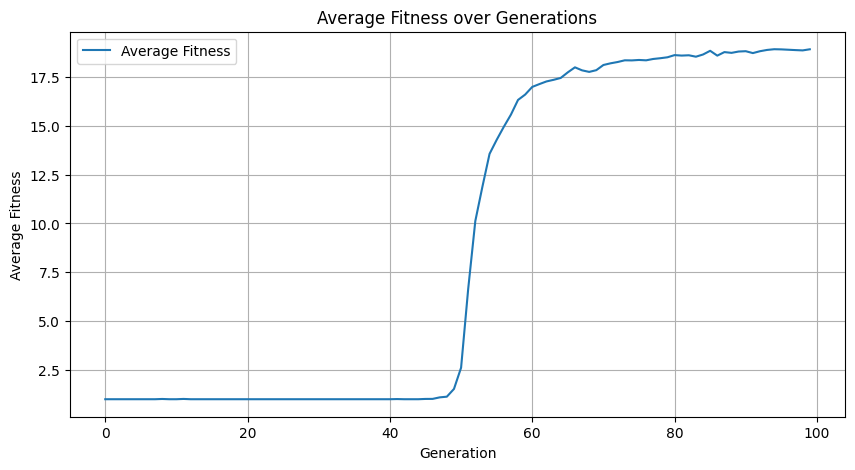

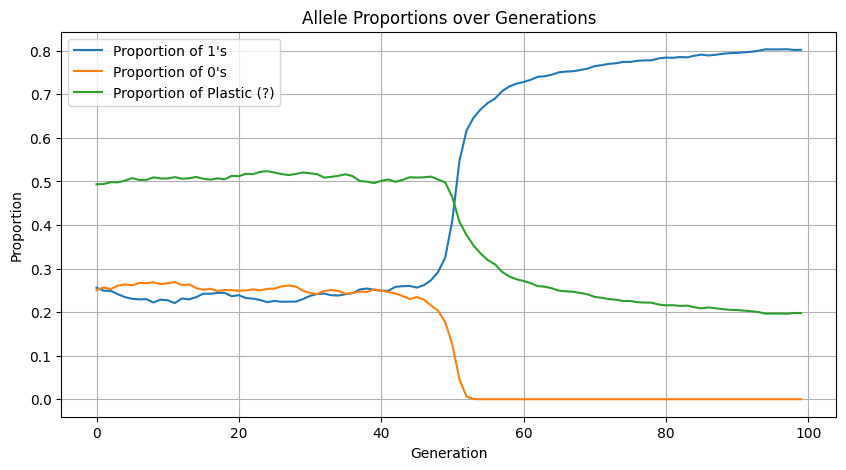

In [3]:
# Plot the average fitness over generations
plt.figure(figsize=(10, 5))
plt.plot(avg_fitness_history, label="Average Fitness")
plt.xlabel("Generation")
plt.ylabel("Average Fitness")
plt.title("Average Fitness over Generations")
plt.legend()
plt.grid(True)
plt.show()

# Plot the allele proportions over generations
plt.figure(figsize=(10, 5))
plt.plot(prop_1_history, label="Proportion of 1's")
plt.plot(prop_0_history, label="Proportion of 0's")
plt.plot(prop_plastic_history, label="Proportion of Plastic (?)")
plt.xlabel("Generation")
plt.ylabel("Proportion")
plt.title("Allele Proportions over Generations")
plt.legend()
plt.grid(True)
plt.show()

In [52]:
def evaluate_with_evolved_p_social(individual, model_population=None, model_phenotypes=None, model_fitnesses=None):
    # Genome structure: [L genotype bits] + [5 strategy bits]
    genotype = individual[:L]
    strategy_bits = individual[L:]
    p_social = decode_strategy_bits(strategy_bits)

    return evaluate_fitness_with_bias(
        genotype,
        model_population=model_population,
        model_phenotypes=model_phenotypes,
        model_fitnesses=model_fitnesses,
        p_social_learning=p_social
    )

## Social Learning Mechanism

In [30]:
def evaluate_fitness_with_bias(individual, model_population=None, model_phenotypes=None, model_fitnesses=None, p_social_learning=0.5):
    phenotype = individual.copy()
    plastic_idx = np.where(individual == 2)[0]

    if np.any(individual == 0):
        phenotype[plastic_idx] = np.random.randint(0, 2, len(plastic_idx))
        return 1.0, phenotype

    guesses_remaining = G_max

    # Decide whether to learn socially or asocially
    if model_population is not None and model_phenotypes is not None and model_fitnesses is not None \
       and len(plastic_idx) > 0 and np.random.rand() < p_social_learning:

        # Select a model from previous generation based on fitness
        model_probs = roulette_wheel_probs(model_fitnesses)
        model_idx = np.random.choice(len(model_population), p=model_probs)
        model_pheno = model_phenotypes[model_idx]

        # Get bias from model's learned phenotype
        num_ones = np.sum(model_pheno == 1)
        num_zeros = np.sum(model_pheno == 0)
        total = num_ones + num_zeros

        if total > 0:
            prob_one = num_ones / total
            prob_zero = num_zeros / total
        else:
            prob_one = prob_zero = 0.5

        # Biased associative guessing
        for guess in range(1, G_max + 1):
            phenotype[plastic_idx] = np.random.choice([1, 0], size=len(plastic_idx), p=[prob_one, prob_zero])
            if np.array_equal(phenotype, target):
                guesses_remaining = guess
                break
    else:
        # Asocial learning
        for guess in range(1, G_max + 1):
            phenotype[plastic_idx] = np.random.randint(0, 2, len(plastic_idx))
            if np.array_equal(phenotype, target):
                guesses_remaining = guess
                break

    fitness = 1 + ((L - 1) * (G_max - guesses_remaining)) / G_max
    return fitness, phenotype

In [39]:
np.random.seed(2025)

pop = initialize_population()
avg_fitness_history = []
prop_1_history = []
prop_0_history = []
prop_plastic_history = []
p_social_learning = 0.0

# These will hold previous generation's data for vertical learning
model_population = None
model_phenotypes = None
model_fitnesses = None

for gen in range(generations):
    fitnesses = []
    phenotypes = []

    for ind in pop:
        fitness, pheno = evaluate_fitness_with_bias(
            ind,
            model_population=model_population,
            model_phenotypes=model_phenotypes,
            model_fitnesses=model_fitnesses,
            p_social_learning=p_social_learning if gen > 0 else 0.0  # First gen = asocial only
        )
        fitnesses.append(fitness)
        phenotypes.append(pheno)

    fitnesses = np.array(fitnesses)
    phenotypes = np.array(phenotypes)

    # Record stats
    avg_fitness_history.append(np.mean(fitnesses))
    flat_pop = pop.flatten()
    prop_1_history.append(np.sum(flat_pop == 1) / flat_pop.size)
    prop_0_history.append(np.sum(flat_pop == 0) / flat_pop.size)
    prop_plastic_history.append(np.sum(flat_pop == 2) / flat_pop.size)

    if (gen+1) % 5 == 0:
        print(f"Gen {gen+1}: avg fitness={np.mean(fitnesses):.2f}, "
              f"p(1)={prop_1_history[-1]:.2f}, p(0)={prop_0_history[-1]:.2f}, p(?)={prop_plastic_history[-1]:.2f}")

    # Save current gen as model population for next generation
    model_population = pop.copy()
    model_phenotypes = phenotypes.copy()
    model_fitnesses = fitnesses.copy()

    # Reproduce
    pop = roulette_wheel_selection(pop, fitnesses)
    pop = create_next_generation(pop, fitnesses)

Gen 5: avg fitness=1.00, p(1)=0.25, p(0)=0.24, p(?)=0.51
Gen 10: avg fitness=1.02, p(1)=0.26, p(0)=0.22, p(?)=0.51
Gen 15: avg fitness=3.40, p(1)=0.39, p(0)=0.09, p(?)=0.52
Gen 20: avg fitness=16.22, p(1)=0.64, p(0)=0.00, p(?)=0.36
Gen 25: avg fitness=17.76, p(1)=0.68, p(0)=0.00, p(?)=0.32
Gen 30: avg fitness=18.62, p(1)=0.72, p(0)=0.00, p(?)=0.28
Gen 35: avg fitness=18.83, p(1)=0.73, p(0)=0.00, p(?)=0.27
Gen 40: avg fitness=18.86, p(1)=0.74, p(0)=0.00, p(?)=0.26
Gen 45: avg fitness=19.16, p(1)=0.75, p(0)=0.00, p(?)=0.25
Gen 50: avg fitness=19.25, p(1)=0.76, p(0)=0.00, p(?)=0.24


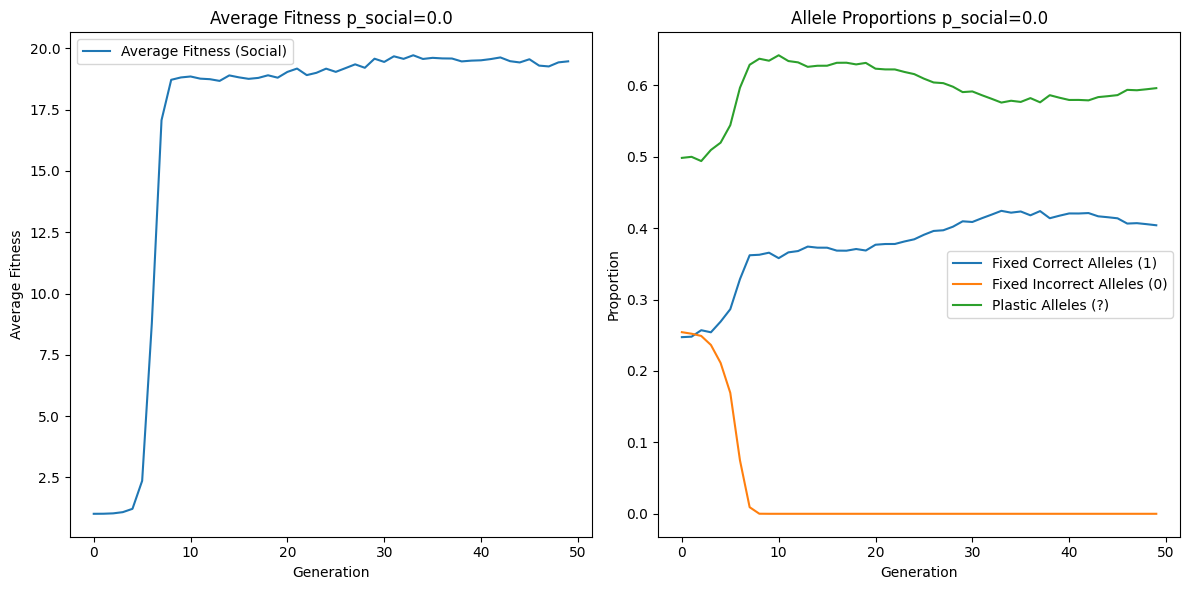

In [40]:
# Plotting Results Clearly
plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.plot(avg_fitness_history_social, label='Average Fitness (Social)')
plt.xlabel('Generation')
plt.ylabel('Average Fitness')
plt.title(f'Average Fitness p_social={p_social_learning}')
plt.legend()

plt.subplot(122)
plt.plot(prop_1_history_social, label='Fixed Correct Alleles (1)')
plt.plot(prop_0_history_social, label='Fixed Incorrect Alleles (0)')
plt.plot(prop_plastic_history_social, label='Plastic Alleles (?)')
plt.xlabel('Generation')
plt.ylabel('Proportion')
plt.title(f'Allele Proportions p_social={p_social_learning}')
plt.legend()

plt.tight_layout()
plt.show()

## Evolving social learning bit -- one bit to specify: whether an agent is social or asocial learner

In [42]:
def initialize_population_with_strategy():
    pop = []
    for _ in range(N):
        genome = np.random.choice([0, 1, 2], size=L, p=init_probs)
        strategy_bit = np.random.choice([0, 1])  # 0 = asocial, 1 = social
        individual = np.append(genome, strategy_bit)
        pop.append(individual)
    return np.array(pop)

np.random.seed(2025)

pop = initialize_population_with_strategy()

avg_fitness_history = []
prop_1_history = []
prop_0_history = []
prop_plastic_history = []
prop_social_history = []

model_population = None
model_phenotypes = None
model_fitnesses = None

for gen in range(generations):
    fitnesses = []
    phenotypes = []

    for ind in pop:
        genotype = ind[:-1]
        strategy_bit = ind[-1]
        p_social = 1.0 if strategy_bit == 1 else 0.0

        fitness, phenotype = evaluate_fitness_with_bias(
            genotype,
            model_population=model_population,
            model_phenotypes=model_phenotypes,
            model_fitnesses=model_fitnesses,
            p_social_learning=p_social if gen > 0 else 0.0  # first gen = asocial
        )

        fitnesses.append(fitness)
        phenotypes.append(phenotype)

    fitnesses = np.array(fitnesses)
    phenotypes = np.array(phenotypes)

    avg_fitness_history.append(np.mean(fitnesses))

    flat_genome = pop[:, :-1].flatten()
    prop_1_history.append(np.sum(flat_genome == 1) / flat_genome.size)
    prop_0_history.append(np.sum(flat_genome == 0) / flat_genome.size)
    prop_plastic_history.append(np.sum(flat_genome == 2) / flat_genome.size)
    prop_social_history.append(np.mean(pop[:, -1]))  # proportion of social learners

    if (gen + 1) % 5 == 0:
        print(f"Gen {gen+1}: fitness={avg_fitness_history[-1]:.2f}, "
              f"p(1)={prop_1_history[-1]:.2f}, p(0)={prop_0_history[-1]:.2f}, "
              f"p(?)={prop_plastic_history[-1]:.2f}, social_learners={prop_social_history[-1]:.2f}")

    model_population = pop[:, :-1].copy()  # only pass genotype to model pop
    model_phenotypes = np.array(phenotypes)
    model_fitnesses = fitnesses.copy()

    # Reproduction
    selected = roulette_wheel_selection(pop, fitnesses)
    new_pop = []

    while len(new_pop) < N:
        p1 = selected[np.random.choice(N)]
        p2 = selected[np.random.choice(N)]
        child = two_point_crossover(p1, p2)

        # Mutate genome + strategy bit
        for i in range(len(child)):
            if np.random.rand() < 0.01:
                if i < L:
                    child[i] = np.random.choice([0, 1, 2])
                else:
                    child[i] = 1 - child[i]  # flip strategy bit

        new_pop.append(child)

    pop = np.array(new_pop)

Gen 5: fitness=1.02, p(1)=0.27, p(0)=0.25, p(?)=0.49, social_learners=0.51
Gen 10: fitness=5.88, p(1)=0.41, p(0)=0.09, p(?)=0.50, social_learners=0.60
Gen 15: fitness=18.23, p(1)=0.54, p(0)=0.00, p(?)=0.46, social_learners=0.95
Gen 20: fitness=18.51, p(1)=0.54, p(0)=0.00, p(?)=0.46, social_learners=0.98
Gen 25: fitness=18.70, p(1)=0.55, p(0)=0.00, p(?)=0.44, social_learners=0.98
Gen 30: fitness=18.61, p(1)=0.56, p(0)=0.00, p(?)=0.44, social_learners=0.97
Gen 35: fitness=18.42, p(1)=0.56, p(0)=0.00, p(?)=0.44, social_learners=0.97
Gen 40: fitness=18.58, p(1)=0.55, p(0)=0.00, p(?)=0.45, social_learners=0.98
Gen 45: fitness=18.46, p(1)=0.55, p(0)=0.00, p(?)=0.45, social_learners=0.98
Gen 50: fitness=18.44, p(1)=0.55, p(0)=0.00, p(?)=0.44, social_learners=0.99


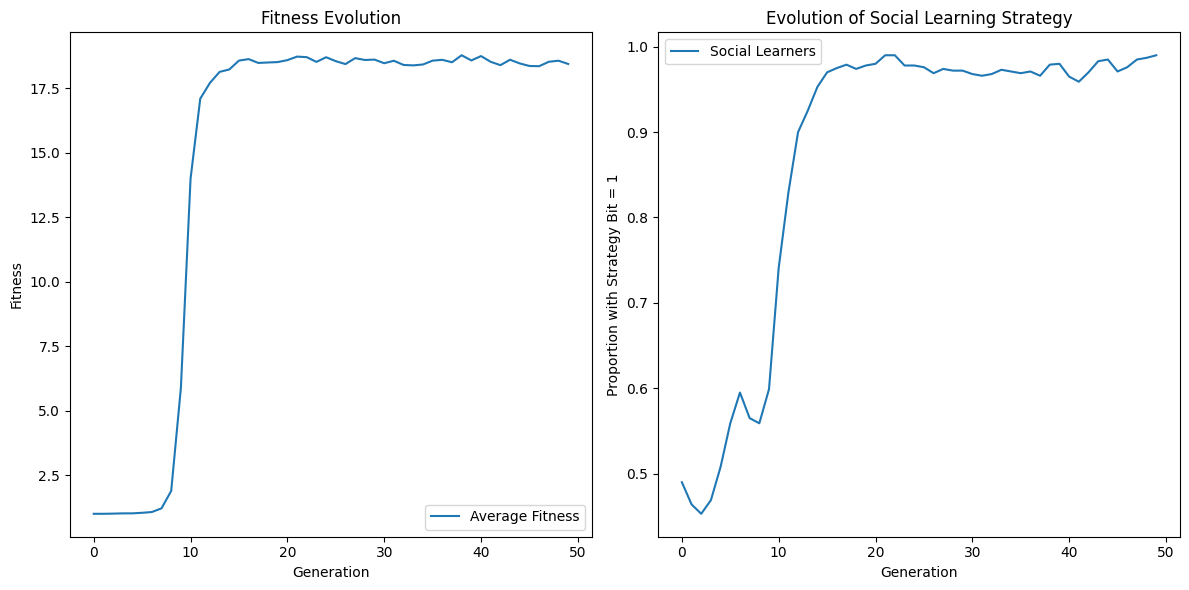

In [46]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(avg_fitness_history, label='Average Fitness')
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("Fitness Evolution")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(prop_social_history, label='Social Learners')
plt.xlabel("Generation")
plt.ylabel("Proportion with Strategy Bit = 1")
plt.title("Evolution of Social Learning Strategy")
plt.legend()

plt.tight_layout()
plt.show()

## Evolving learning strategy

In [53]:
def initialize_population_with_strategy_bits():
    pop = []
    for _ in range(N):
        genome = np.random.choice([0, 1, 2], size=L, p=init_probs)
        strategy_bits = np.random.choice([0, 1], size=5)  # 5 binary bits
        individual = np.concatenate((genome, strategy_bits))
        pop.append(individual)
    return np.array(pop)

In [59]:
from scipy.stats import spearmanr, ttest_ind, entropy
import scipy

np.random.seed(2025)

pop = initialize_population_with_strategy_bits()

avg_fitness_history = []
prop_1_history = []
prop_0_history = []
prop_plastic_history = []
avg_p_social_history = []

# Create histories
avg_fitness_social_history = []
avg_fitness_asocial_history = []
correlation_social_fit_history = []
strategy_entropy_history = []
top_strategy_type_history = []


model_population = None
model_phenotypes = None
model_fitnesses = None

for gen in range(generations):
    fitnesses = []
    phenotypes = []
    p_socials = []

    for ind in pop:
        fitness, phenotype = evaluate_with_evolved_p_social(
            ind,
            model_population=model_population,
            model_phenotypes=model_phenotypes,
            model_fitnesses=model_fitnesses if gen > 0 else None  # first gen = no social
        )
        fitnesses.append(fitness)
        phenotypes.append(phenotype)
        p_socials.append(decode_strategy_bits(ind[L:]))

    fitnesses = np.array(fitnesses)
    phenotypes = np.array(phenotypes)
    avg_fitness_history.append(np.mean(fitnesses))
    avg_p_social_history.append(np.mean(p_socials))

    flat_genome = pop[:, :L].flatten()
    prop_1_history.append(np.sum(flat_genome == 1) / flat_genome.size)
    prop_0_history.append(np.sum(flat_genome == 0) / flat_genome.size)
    prop_plastic_history.append(np.sum(flat_genome == 2) / flat_genome.size)


    # Group learners
    social_fitnesses = [f for ind, f in zip(pop, fitnesses) if decode_strategy_bits(ind[L:]) >= 0.5]
    asocial_fitnesses = [f for ind, f in zip(pop, fitnesses) if decode_strategy_bits(ind[L:]) < 0.5]

    avg_fitness_social_history.append(np.mean(social_fitnesses) if social_fitnesses else np.nan)
    avg_fitness_asocial_history.append(np.mean(asocial_fitnesses) if asocial_fitnesses else np.nan)

    # Correlation between p_social and fitness
    p_social_vals = [decode_strategy_bits(ind[L:]) for ind in pop]
    correlation, _ = spearmanr(p_social_vals, fitnesses)
    correlation_social_fit_history.append(correlation)

    # Strategy entropy
    hist, _ = np.histogram(p_social_vals, bins=10, range=(0, 1), density=True)
    entropy = scipy.stats.entropy(hist + 1e-9)
    strategy_entropy_history.append(entropy)

    # Did the top individual use social learning?
    best_idx = np.argmax(fitnesses)
    top_strategy = decode_strategy_bits(pop[best_idx][L:])
    top_strategy_type_history.append(1 if top_strategy >= 0.5 else 0)

    if (gen+1) % 5 == 0:
        print(f"Gen {gen+1}: fitness={avg_fitness_history[-1]:.2f}, "
              f"p(1)={prop_1_history[-1]:.2f}, p(0)={prop_0_history[-1]:.2f}, "
              f"p(?)={prop_plastic_history[-1]:.2f}, avg_p_social={avg_p_social_history[-1]:.2f}")

    model_population = pop[:, :L].copy()
    model_phenotypes = phenotypes.copy()
    model_fitnesses = fitnesses.copy()

    selected = roulette_wheel_selection(pop, fitnesses)
    new_pop = []

    while len(new_pop) < N:
        p1 = selected[np.random.choice(N)]
        p2 = selected[np.random.choice(N)]
        child = two_point_crossover(p1, p2)

        # Mutate genome and strategy bits
        for i in range(len(child)):
            if np.random.rand() < 0.01:
                if i < L:
                    child[i] = np.random.choice([0, 1, 2])
                else:
                    child[i] = 1 - child[i]  # flip strategy bit

        new_pop.append(child)

    pop = np.array(new_pop)

/var/folders/rg/51qx40ys3pzbkw66znkhns340000gn/T/ipykernel_93119/855767158.py:62: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, _ = spearmanr(p_social_vals, fitnesses)


Gen 5: fitness=1.10, p(1)=0.28, p(0)=0.25, p(?)=0.47, avg_p_social=0.55
Gen 10: fitness=15.12, p(1)=0.55, p(0)=0.00, p(?)=0.45, avg_p_social=0.50
Gen 15: fitness=16.44, p(1)=0.60, p(0)=0.00, p(?)=0.40, avg_p_social=0.60
Gen 20: fitness=17.41, p(1)=0.62, p(0)=0.00, p(?)=0.38, avg_p_social=0.63
Gen 25: fitness=17.46, p(1)=0.62, p(0)=0.00, p(?)=0.38, avg_p_social=0.70
Gen 30: fitness=17.97, p(1)=0.65, p(0)=0.00, p(?)=0.34, avg_p_social=0.75
Gen 35: fitness=17.91, p(1)=0.67, p(0)=0.00, p(?)=0.32, avg_p_social=0.77
Gen 40: fitness=18.04, p(1)=0.68, p(0)=0.00, p(?)=0.32, avg_p_social=0.75
Gen 45: fitness=18.14, p(1)=0.68, p(0)=0.00, p(?)=0.32, avg_p_social=0.77
Gen 50: fitness=18.37, p(1)=0.68, p(0)=0.00, p(?)=0.31, avg_p_social=0.77


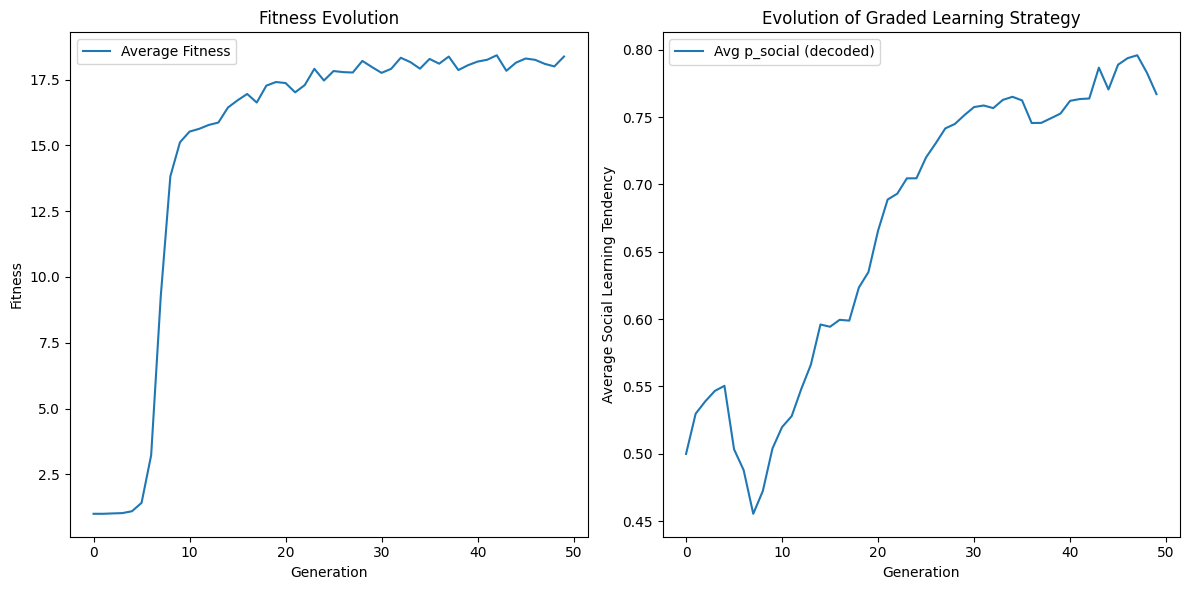

In [60]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(avg_fitness_history, label='Average Fitness')
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("Fitness Evolution")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(avg_p_social_history, label='Avg p_social (decoded)')
plt.xlabel("Generation")
plt.ylabel("Average Social Learning Tendency")
plt.title("Evolution of Graded Learning Strategy")
plt.legend()

plt.tight_layout()
plt.show()

In [65]:
from scipy.stats import ttest_ind

last_social = avg_fitness_social_history[-10:]
last_asocial = avg_fitness_asocial_history[-10:]
t_stat, p_value = ttest_ind(last_social, last_asocial, nan_policy='omit')
print(f"T-test (last 10 gens): t={t_stat:.3f}, p={p_value:.4f}")

T-test (last 10 gens): t=5.501, p=0.0000


In [51]:
def decode_strategy_bits(strategy_bits):
    # Binary array (length 5) to int
    binary_string = ''.join(str(int(b)) for b in strategy_bits)
    decimal_value = int(binary_string, 2)
    # Normalize to [0, 1]
    max_value = 2**len(strategy_bits) - 1
    return decimal_value / max_value

In [62]:
corr_trend, p_corr_trend = spearmanr(range(generations), correlation_social_fit_history)
print(f"Spearman correlation trend: rho={corr_trend:.2f}, p={p_corr_trend:.4f}")

Spearman correlation trend: rho=nan, p=nan


In [66]:
pvals = [decode_strategy_bits(ind[L:]) for ind in pop]
print("Unique p_social values in population:", np.unique(pvals))
print("Any NaNs?", np.any(np.isnan(pvals)), np.any(np.isnan(fitnesses)))

Unique p_social values in population: [0.         0.03225806 0.09677419 0.12903226 0.16129032 0.25806452
 0.29032258 0.32258065 0.35483871 0.38709677 0.41935484 0.4516129
 0.48387097 0.51612903 0.5483871  0.58064516 0.61290323 0.64516129
 0.67741935 0.70967742 0.74193548 0.77419355 0.80645161 0.83870968
 0.87096774 0.90322581 0.93548387 0.96774194 1.        ]
Any NaNs? False False


In [67]:
# Remove NaNs before trend analysis
valid_corrs = [c for c in correlation_social_fit_history if not np.isnan(c)]
valid_gens = [i for i, c in enumerate(correlation_social_fit_history) if not np.isnan(c)]

if len(valid_corrs) >= 2:
    trend_corr, trend_p = spearmanr(valid_gens, valid_corrs)
    print(f"Trend in correlation: rho = {trend_corr:.3f}, p = {trend_p:.4f}")
else:
    print("Not enough valid correlation values to compute trend.")

Trend in correlation: rho = -0.032, p = 0.8306


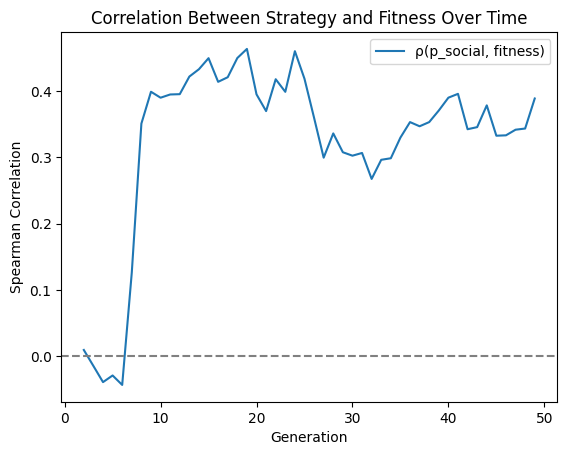

In [68]:
plt.plot(correlation_social_fit_history, label="ρ(p_social, fitness)")
plt.axhline(0, linestyle="--", color="gray")
plt.xlabel("Generation")
plt.ylabel("Spearman Correlation")
plt.title("Correlation Between Strategy and Fitness Over Time")
plt.legend()
plt.show()

In [72]:
from scipy.stats import ttest_ind, wilcoxon
import numpy as np

# Get early and late correlation values (replace these if needed)
early_corrs = np.array(correlation_social_fit_history[:10])
late_corrs = np.array(correlation_social_fit_history[-10:])

# Filter out NaNs
early_corrs = early_corrs[~np.isnan(early_corrs)]
late_corrs = late_corrs[~np.isnan(late_corrs)]

print(f"Early correlation avg: {np.mean(early_corrs):.3f}")
print(f"Late correlation avg: {np.mean(late_corrs):.3f}")

# --- Run t-test (does not require equal length) ---
if len(early_corrs) >= 2 and len(late_corrs) >= 2:
    t_stat, p_ttest = ttest_ind(late_corrs, early_corrs, equal_var=False)
    print(f"T-test: t = {t_stat:.3f}, p = {p_ttest:.4f}")
else:
    print("⚠️ Not enough data for t-test.")

# --- Run Wilcoxon signed-rank test (requires same length) ---
if len(early_corrs) == len(late_corrs) and len(early_corrs) > 0:
    w_stat, p_wilcoxon = wilcoxon(late_corrs, early_corrs)
    print(f"Wilcoxon signed-rank: W = {w_stat:.3f}, p = {p_wilcoxon:.4f}")
else:
    print(f"⚠️ Wilcoxon skipped: unequal lengths or insufficient data ({len(early_corrs)} vs {len(late_corrs)})")

Early correlation avg: 0.095
Late correlation avg: 0.359
T-test: t = 4.084, p = 0.0044
⚠️ Wilcoxon skipped: unequal lengths or insufficient data (8 vs 10)


# A simple continuous needle-in-a-haystack: Gaussian function

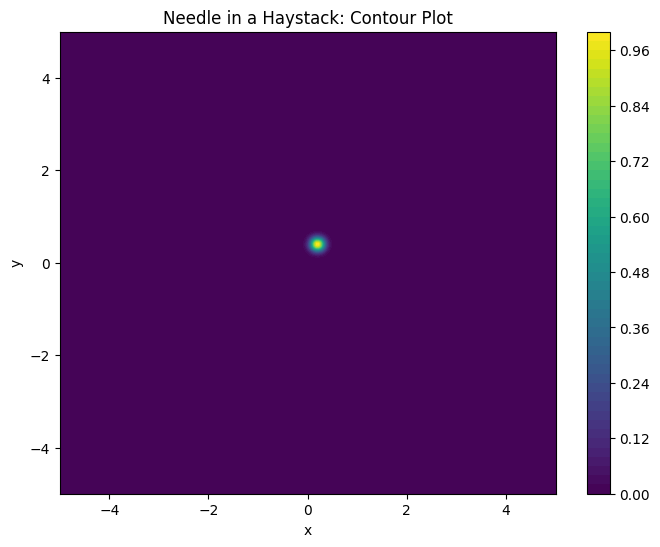

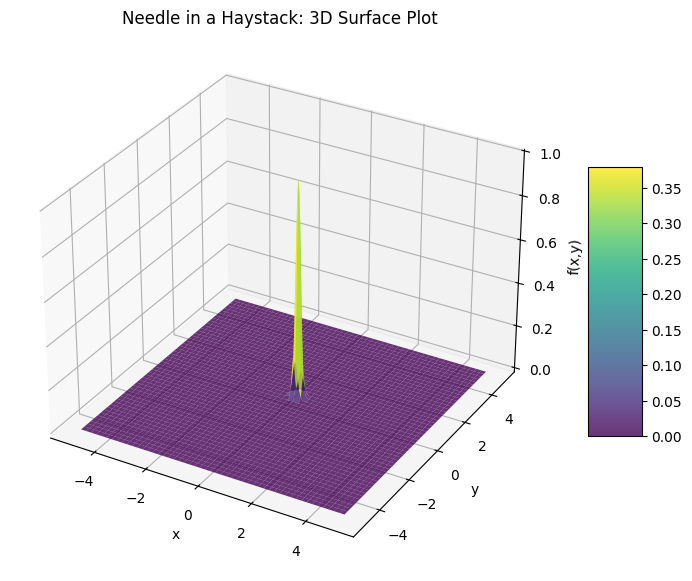

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # For 3D plotting

# Define the continuous function: a narrow Gaussian peak (the "needle")
def needle_in_haystack(x, y, x_star=0.2, y_star=0.4, sigma=0.1):
    # f(x, y) = exp(-((x - x*)^2 + (y - y*)^2) / (2*sigma^2))
    return np.exp(-((x - x_star)**2 + (y - y_star)**2) / (2 * sigma**2))

# Create a grid of (x, y) points
x_range = np.linspace(-5, 5, 400)
y_range = np.linspace(-5, 5, 400)
X, Y = np.meshgrid(x_range, y_range)

# Evaluate the function on the grid
Z = needle_in_haystack(X, Y)

# Plot the landscape using a contour plot
plt.figure(figsize=(8, 6))
contour = plt.contourf(X, Y, Z, levels=50, cmap='viridis')
plt.colorbar(contour)
plt.title("Needle in a Haystack: Contour Plot")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

# Alternatively, plot a 3D surface plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none', alpha=0.8)
ax.set_title("Needle in a Haystack: 3D Surface Plot")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("f(x,y)")
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

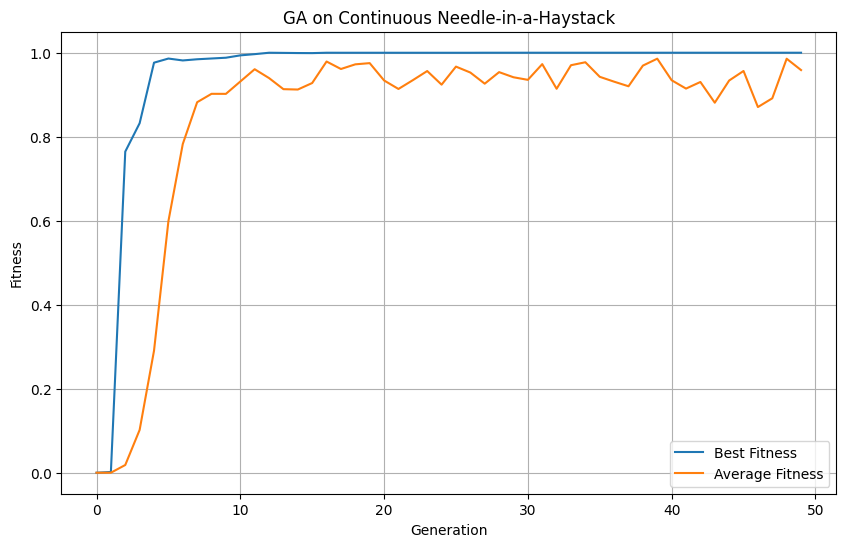

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Define the "needle in a haystack" fitness function:
def needle_in_haystack(x, y, x_star=0.2, y_star=0.2, sigma=0.1):
    # Narrow Gaussian: maximum at (x_star, y_star)
    return np.exp(-((x - x_star)**2 + (y - y_star)**2) / (2 * sigma**2))

# GA parameters
pop_size = 50             # Population size
generations = 50          # Number of generations
domain = [-5, 5]           # Search space bounds for both x and y
tournament_size = 3        # Tournament selection size
mutation_rate = 0.1        # Mutation probability per coordinate
mutation_std = 0.1         # Standard deviation for Gaussian mutation

# Initialize population uniformly in the domain:
population = np.random.uniform(domain[0], domain[1], (pop_size, 2))

# Evaluate fitness for the entire population:
def evaluate_population(pop):
    # pop is an array of shape (pop_size, 2)
    fitnesses = needle_in_haystack(pop[:, 0], pop[:, 1])
    return fitnesses

# Tournament selection: randomly select a few individuals and pick the best.
def tournament_selection(pop, fitnesses, tournament_size=3):
    indices = np.random.choice(np.arange(len(pop)), size=tournament_size, replace=False)
    tournament = pop[indices]
    tournament_fitness = fitnesses[indices]
    best_index = np.argmax(tournament_fitness)
    return tournament[best_index]

# Crossover: arithmetic crossover between two parents.
def crossover(parent1, parent2):
    alpha = np.random.rand()
    offspring = alpha * parent1 + (1 - alpha) * parent2
    return offspring

# Mutation: add Gaussian noise to each coordinate with probability mutation_rate.
def mutate(individual, mutation_std=0.1, mutation_rate=0.1, domain=domain):
    for i in range(len(individual)):
        if np.random.rand() < mutation_rate:
            individual[i] += np.random.normal(0, mutation_std)
            # Ensure the mutated value stays within the domain.
            individual[i] = np.clip(individual[i], domain[0], domain[1])
    return individual

# GA loop:
best_fitness_history = []
avg_fitness_history = []

for gen in range(generations):
    fitnesses = evaluate_population(population)
    best_fitness = np.max(fitnesses)
    avg_fitness = np.mean(fitnesses)
    best_fitness_history.append(best_fitness)
    avg_fitness_history.append(avg_fitness)
    
    new_population = []
    # Generate a new generation until we have pop_size offspring.
    while len(new_population) < pop_size:
        # Select two parents via tournament selection.
        parent1 = tournament_selection(population, fitnesses, tournament_size)
        parent2 = tournament_selection(population, fitnesses, tournament_size)
        # Produce one offspring via crossover.
        offspring = crossover(parent1, parent2)
        # Mutate the offspring.
        offspring = mutate(offspring, mutation_std, mutation_rate, domain)
        new_population.append(offspring)
    
    population = np.array(new_population)

# Plot the evolution of best and average fitness over generations.
plt.figure(figsize=(10, 6))
plt.plot(best_fitness_history, label="Best Fitness")
plt.plot(avg_fitness_history, label="Average Fitness")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("GA on Continuous Needle-in-a-Haystack")
plt.legend()
plt.grid(True)
plt.show()

## Evolution Alone

Generation 50: Best Fitness = 0.9766, Average Fitness = 0.8539
Generation 100: Best Fitness = 0.9894, Average Fitness = 0.8655
Generation 150: Best Fitness = 0.9898, Average Fitness = 0.8672
Generation 200: Best Fitness = 0.9908, Average Fitness = 0.8773
Generation 250: Best Fitness = 0.9883, Average Fitness = 0.8823
Generation 300: Best Fitness = 0.9894, Average Fitness = 0.8813


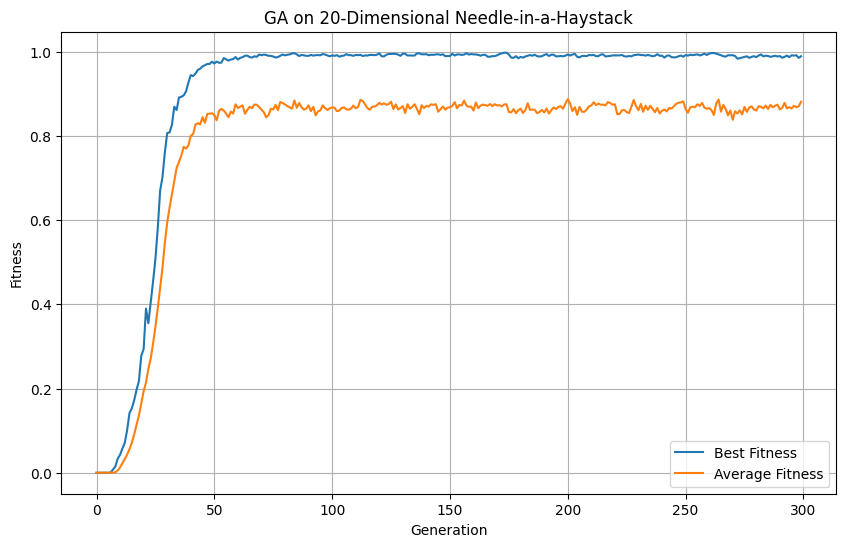

In [4]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)

# Define the high-dimensional needle-in-a-haystack fitness function
def needle_in_haystack_nd(x, x_star=None, sigma=0.3):
    # x: candidate solution, a 1D array of dimension D.
    # x_star: optimal solution, defaults to the zero vector if not provided.
    if x_star is None:
        x_star = np.zeros_like(x)
    # Euclidean distance squared:
    dist2 = np.sum((x - x_star)**2)
    return np.exp(-dist2 / (2 * sigma**2))

# GA parameters for high-dimensional problem
D = 20                   # Dimensionality (e.g., 10 dimensions)
pop_size = 200           # Population size
generations = 300        # Number of generations
domain = [-5, 5]         # Search space bounds for each dimension
tournament_size = 3      # Tournament selection size
mutation_rate = 0.1      # Mutation probability per coordinate
mutation_std = 0.1       # Std. dev. for Gaussian mutation

# Initialize population uniformly in D dimensions:
population = np.random.uniform(domain[0], domain[1], (pop_size, D))

def evaluate_population_nd(pop):
    # Evaluate fitness for a population of candidates in D dimensions.
    fitnesses = np.array([needle_in_haystack_nd(ind) for ind in pop])
    return fitnesses

def tournament_selection(pop, fitnesses, tournament_size=3):
    indices = np.random.choice(np.arange(len(pop)), size=tournament_size, replace=False)
    tournament = pop[indices]
    tournament_fitness = fitnesses[indices]
    best_index = np.argmax(tournament_fitness)
    return tournament[best_index]

# Arithmetic crossover between two parents
def crossover(parent1, parent2):
    alpha = np.random.rand()
    offspring = alpha * parent1 + (1 - alpha) * parent2
    return offspring

def mutate(individual, mutation_std=0.1, mutation_rate=0.1, domain=domain):
    for i in range(len(individual)):
        if np.random.rand() < mutation_rate:
            individual[i] += np.random.normal(0, mutation_std)
            individual[i] = np.clip(individual[i], domain[0], domain[1])
    return individual

# GA loop for high-dimensional problem:
best_fitness_history_nd = []
avg_fitness_history_nd = []

for gen in range(generations):
    fitnesses = evaluate_population_nd(population)
    best_fitness = np.max(fitnesses)
    avg_fitness = np.mean(fitnesses)
    best_fitness_history_nd.append(best_fitness)
    avg_fitness_history_nd.append(avg_fitness)
    
    new_population = []
    while len(new_population) < pop_size:
        parent1 = tournament_selection(population, fitnesses, tournament_size)
        parent2 = tournament_selection(population, fitnesses, tournament_size)
        offspring = crossover(parent1, parent2)
        offspring = mutate(offspring, mutation_std, mutation_rate, domain)
        new_population.append(offspring)
    population = np.array(new_population)
    
    if (gen+1) % 50 == 0:
        print(f"Generation {gen+1}: Best Fitness = {best_fitness:.4f}, Average Fitness = {avg_fitness:.4f}")

# Plot the evolution of best and average fitness over generations.
plt.figure(figsize=(10, 6))
plt.plot(best_fitness_history_nd, label="Best Fitness")
plt.plot(avg_fitness_history_nd, label="Average Fitness")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title(f"GA on {D}-Dimensional Needle-in-a-Haystack")
plt.legend()
plt.grid(True)
plt.show()

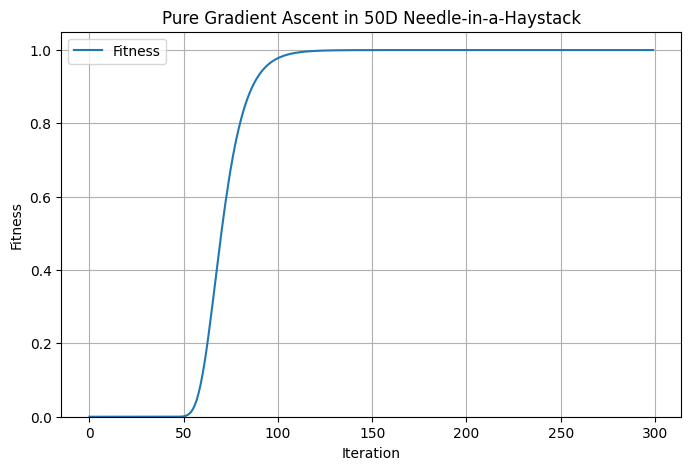

Final fitness: 1.000000
Final point norm: 0.000001


In [16]:
import numpy as np
import matplotlib.pyplot as plt

# High-dimensional "needle in a haystack" fitness function:
def needle_in_haystack_nd(x, sigma=0.3):
    dist2 = np.sum(x**2)
    return np.exp(-dist2 / (2 * sigma**2))

# Gradient of log(f(x)):
# log f(x) = -||x||^2 / (2 sigma^2)
# grad(log f(x)) = -x / sigma^2
def gradient_of_log_f(x, sigma=0.3):
    return -x / (sigma**2)

def pure_gradient_ascent(dim=100, sigma=0.3, domain=(-5, 5), 
                         lr=0.005, steps=300):
    """
    Performs gradient ascent on log(f(x)) for the needle in a haystack function.
    Returns arrays of (fitness_history, x_history).
    """
    # Random initial point in [domain[0], domain[1]]^dim
    x = np.random.uniform(domain[0], domain[1], size=dim)
    
    fitness_history = []
    x_history = []
    
    for _ in range(steps):
        # Evaluate current fitness
        fit = needle_in_haystack_nd(x, sigma)
        fitness_history.append(fit)
        x_history.append(x.copy())
        
        # Compute gradient of log(f(x)) and perform a gradient ascent step
        grad_logf = gradient_of_log_f(x, sigma)
        x = x + lr * grad_logf
        
        # Keep x within the domain
        x = np.clip(x, domain[0], domain[1])
    
    return np.array(fitness_history), np.array(x_history)

# Parameters
dim = 50
sigma = 0.3
domain = (-5, 5)
lr = 0.005
steps = 300

# Run gradient ascent
fitness_history, x_history = pure_gradient_ascent(
    dim=dim, sigma=sigma, domain=domain, lr=lr, steps=steps
)

# Plot fitness over iterations
plt.figure(figsize=(8,5))
plt.plot(fitness_history, label="Fitness")
plt.title(f"Pure Gradient Ascent in {dim}D Needle-in-a-Haystack")
plt.xlabel("Iteration")
plt.ylabel("Fitness")
plt.ylim([0,1.05])
plt.grid(True)
plt.legend()
plt.show()

# Print final results
print(f"Final fitness: {fitness_history[-1]:.6f}")
print(f"Final point norm: {np.linalg.norm(x_history[-1]):.6f}")

## Dynamic Environments

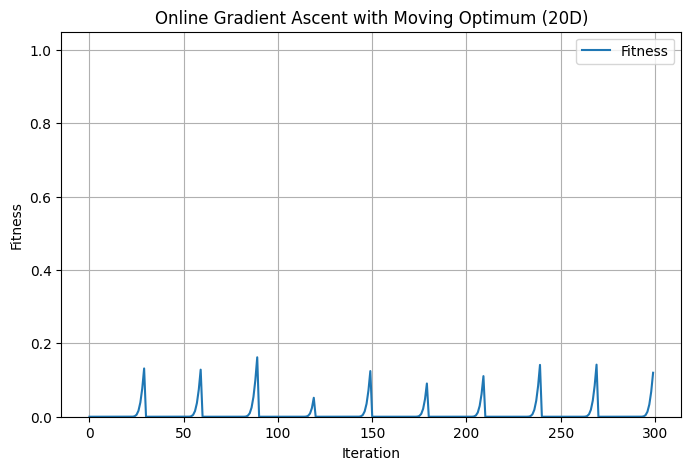

Final fitness: 0.119954
Final location norm: 11.835801


In [17]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(2025)

# Parameters
dim = 20              # Dimensionality of the problem
steps = 300           # Total number of iterations
domain = (-5, 5)      # Bounds for each coordinate
sigma = 0.3           # Width of the Gaussian peak
lr = 0.01             # Learning rate for gradient ascent on log fitness
change_interval = 30  # Number of steps before the optimum moves

# Function: f(x, x_star) = exp(-||x - x_star||^2 / (2 * sigma^2))
def needle_in_haystack_moving(x, x_star, sigma=0.3):
    dist2 = np.sum((x - x_star)**2)
    return np.exp(-dist2 / (2 * sigma**2))

# Gradient of log f(x, x_star):
# log f(x, x_star) = -||x - x_star||^2 / (2 sigma^2)
# => ∇ log f = -(x - x_star) / sigma^2
def grad_log_f(x, x_star, sigma=0.3):
    return -(x - x_star) / (sigma**2)

# We define a function that updates x_star(t) every "change_interval" steps
def generate_x_star_sequence(num_steps, dim, domain, change_interval):
    """
    Returns an array x_star_seq of shape (num_steps, dim),
    where x_star_seq[t] is the optimum location at iteration t.
    Each time we hit a multiple of change_interval, we pick a new random location.
    """
    x_star_seq = np.zeros((num_steps, dim))
    current_optimum = np.random.uniform(domain[0], domain[1], size=dim)
    for t in range(num_steps):
        if t % change_interval == 0 and t > 0:
            # Move the optimum to a new random location
            current_optimum = np.random.uniform(domain[0], domain[1], size=dim)
        x_star_seq[t] = current_optimum
    return x_star_seq

# Generate a sequence of optimum locations (the moving needle)
x_star_seq = generate_x_star_sequence(steps, dim, domain, change_interval)

# Initialize x randomly
x = np.random.uniform(domain[0], domain[1], size=dim)

fitness_history = []

for t in range(steps):
    # Compute current fitness
    fit = needle_in_haystack_moving(x, x_star_seq[t], sigma)
    fitness_history.append(fit)
    
    # Compute gradient of log f
    g = grad_log_f(x, x_star_seq[t], sigma)
    
    # Gradient ascent step
    x = x + lr * g
    
    # Clip to domain
    x = np.clip(x, domain[0], domain[1])

# Plot the fitness over time
plt.figure(figsize=(8, 5))
plt.plot(fitness_history, label="Fitness")
plt.title(f"Online Gradient Ascent with Moving Optimum ({dim}D)")
plt.xlabel("Iteration")
plt.ylabel("Fitness")
plt.ylim([0, 1.05])
plt.grid(True)
plt.legend()
plt.show()

print(f"Final fitness: {fitness_history[-1]:.6f}")
print(f"Final location norm: {np.linalg.norm(x):.6f}")

### GAs + Gradient Ascent

Generation 30: Best Fitness = 0.952023, Average Fitness = 0.908630
Generation 60: Best Fitness = 0.999995, Average Fitness = 0.965642
Generation 90: Best Fitness = 0.950766, Average Fitness = 0.919879
Generation 120: Best Fitness = 0.996158, Average Fitness = 0.937354
Generation 150: Best Fitness = 0.961132, Average Fitness = 0.911202
Generation 180: Best Fitness = 0.999398, Average Fitness = 0.956484
Generation 210: Best Fitness = 0.957471, Average Fitness = 0.918859
Generation 240: Best Fitness = 0.999158, Average Fitness = 0.979128
Generation 270: Best Fitness = 0.956290, Average Fitness = 0.928347
Generation 300: Best Fitness = 0.999110, Average Fitness = 0.942394


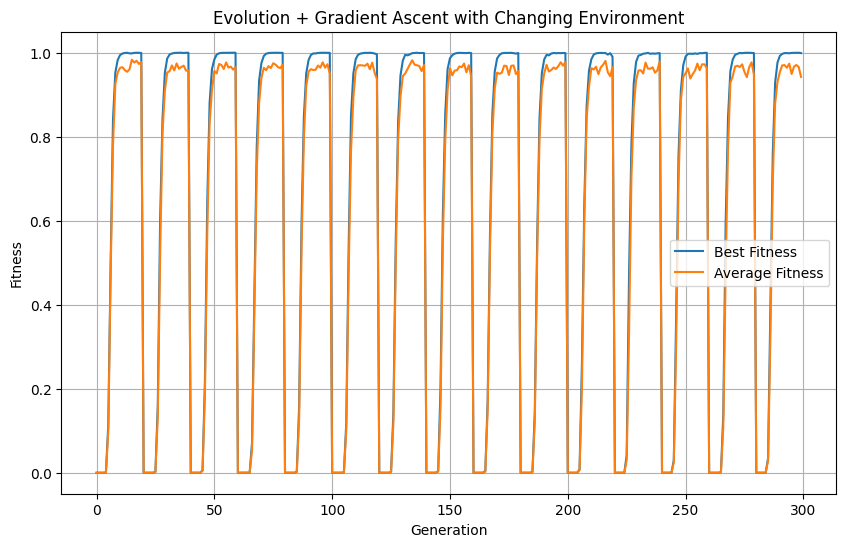

In [5]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(2025)

# ---- Parameters ----
D = 20                   # Dimensionality
pop_size = 20            # Population size
generations = 300         # Number of generations
domain = [-5, 5]          # Bounds for each coordinate
sigma = 0.3               # Width of the Gaussian peak
tournament_size = 3       # Tournament selection size
mutation_rate = 0.1       # Mutation probability per coordinate
mutation_std = 0.1        # Std. dev. for Gaussian mutation

# Gradient ascent (local search) parameters:
gd_steps = 10             # Number of gradient ascent steps per offspring
lr = 0.005                # Learning rate for gradient ascent

# Environment dynamics: change optimum every 'change_interval' generations.
change_interval = 20

# ---- Moving Optimum Functions ----
def generate_x_star_seq(num_gens, dim, domain, change_interval):
    """
    Generate a sequence of optimum positions (x_star) for each generation.
    Every 'change_interval' generations, pick a new random optimum.
    """
    x_star_seq = np.zeros((num_gens, dim))
    current_optimum = np.random.uniform(domain[0], domain[1], size=dim)
    for gen in range(num_gens):
        if gen % change_interval == 0 and gen > 0:
            current_optimum = np.random.uniform(domain[0], domain[1], size=dim)
        x_star_seq[gen] = current_optimum
    return x_star_seq

# Our fitness function (moving optimum version):
# f(x, x_star) = exp( -||x - x_star||^2 / (2*sigma^2) )
def fitness_fn(x, x_star, sigma=sigma):
    dist2 = np.sum((x - x_star)**2)
    return np.exp(-dist2 / (2 * sigma**2))

# The gradient of log fitness:
# log f(x, x_star) = -||x - x_star||^2 / (2*sigma^2)
# ∇ log f(x, x_star) = -(x - x_star) / sigma^2
def grad_log_f(x, x_star, sigma=sigma):
    return -(x - x_star) / (sigma**2)

# ---- GA Operators ----
def evaluate_population(pop, current_x_star):
    # Evaluate fitness for each individual with respect to current optimum.
    fitnesses = np.array([fitness_fn(ind, current_x_star) for ind in pop])
    return fitnesses

def tournament_selection(pop, fitnesses, tournament_size=tournament_size):
    indices = np.random.choice(np.arange(len(pop)), size=tournament_size, replace=False)
    tournament = pop[indices]
    tournament_fitness = fitnesses[indices]
    best_index = np.argmax(tournament_fitness)
    return tournament[best_index]

def crossover(parent1, parent2):
    # Arithmetic crossover.
    alpha = np.random.rand()
    return alpha * parent1 + (1 - alpha) * parent2

def mutate(individual, mutation_std=mutation_std, mutation_rate=mutation_rate, domain=domain):
    for i in range(len(individual)):
        if np.random.rand() < mutation_rate:
            individual[i] += np.random.normal(0, mutation_std)
            individual[i] = np.clip(individual[i], domain[0], domain[1])
    return individual

def gradient_ascent(candidate, current_x_star, lr=lr, n_steps=gd_steps, sigma=sigma, domain=domain):
    x = candidate.copy()
    for _ in range(n_steps):
        grad = grad_log_f(x, current_x_star, sigma)
        x = x + lr * grad
        x = np.clip(x, domain[0], domain[1])
    return x

# ---- Generate Moving Optimum Sequence ----
x_star_seq = generate_x_star_seq(generations, D, domain, change_interval)

# ---- Initialize Population ----
population = np.random.uniform(domain[0], domain[1], (pop_size, D))

# ---- GA + Gradient Ascent Loop (with a Changing Environment) ----
best_fitness_history = []
avg_fitness_history = []

for gen in range(generations):
    current_x_star = x_star_seq[gen]
    fitnesses = evaluate_population(population, current_x_star)
    best_fit = np.max(fitnesses)
    avg_fit = np.mean(fitnesses)
    best_fitness_history.append(best_fit)
    avg_fitness_history.append(avg_fit)
    
    new_population = []
    # Create new generation using selection, crossover, mutation and gradient ascent.
    while len(new_population) < pop_size:
        parent1 = tournament_selection(population, fitnesses)
        parent2 = tournament_selection(population, fitnesses)
        offspring = crossover(parent1, parent2)
        offspring = mutate(offspring, mutation_std, mutation_rate, domain)
        # Apply gradient ascent using the current optimum.
        offspring = gradient_ascent(offspring, current_x_star, lr, gd_steps, sigma, domain)
        new_population.append(offspring)
    
    population = np.array(new_population)
    
    if (gen+1) % 30 == 0:
        print(f"Generation {gen+1}: Best Fitness = {best_fit:.6f}, Average Fitness = {avg_fit:.6f}")

# ---- Plotting Results ----
plt.figure(figsize=(10, 6))
plt.plot(best_fitness_history, label="Best Fitness")
plt.plot(avg_fitness_history, label="Average Fitness")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("Evolution + Gradient Ascent with Changing Environment")
plt.legend()
plt.grid(True)
plt.show()

Run 1 completed.
Run 2 completed.
Run 3 completed.
Run 4 completed.
Run 5 completed.
Run 6 completed.
Run 7 completed.
Run 8 completed.
Run 9 completed.
Run 10 completed.
Run 11 completed.
Run 12 completed.
Run 13 completed.
Run 14 completed.
Run 15 completed.
Run 16 completed.
Run 17 completed.
Run 18 completed.
Run 19 completed.
Run 20 completed.


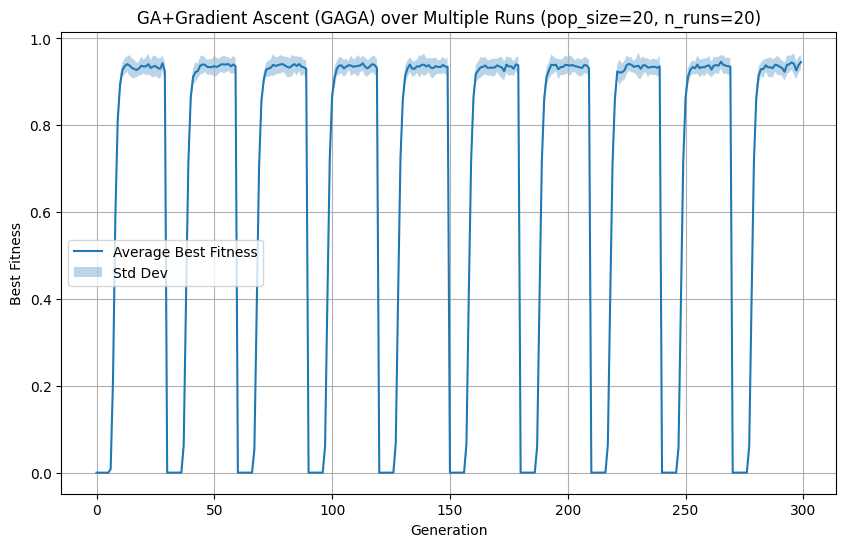

In [55]:
import numpy as np
import matplotlib.pyplot as plt

# ---- Parameters ----
D = 100                   # Dimensionality
pop_size = 20             # Small population size
generations = 300         # Number of generations per run
n_runs = 20               # Number of independent runs
domain = [-5, 5]          # Domain bounds for each coordinate
sigma = 0.3               # Width of the Gaussian peak
tournament_size = 3       # Tournament selection size
mutation_rate = 0.1       # Mutation probability per coordinate
mutation_std = 0.1        # Standard deviation for Gaussian mutation

# Gradient ascent parameters:
gd_steps = 10             # Number of gradient ascent steps per offspring
lr = 0.005                # Learning rate for gradient ascent

# Environment dynamics: optimum changes every 'change_interval' generations.
change_interval = 30

# ---- Functions for the Moving Optimum ----
def generate_x_star_seq(num_gens, dim, domain, change_interval):
    """
    Generate a sequence of optimum positions (x_star) for each generation.
    Every 'change_interval' generations, the optimum jumps to a new random position.
    """
    x_star_seq = np.zeros((num_gens, dim))
    current_optimum = np.random.uniform(domain[0], domain[1], size=dim)
    for gen in range(num_gens):
        if gen % change_interval == 0 and gen > 0:
            current_optimum = np.random.uniform(domain[0], domain[1], size=dim)
        x_star_seq[gen] = current_optimum
    return x_star_seq

def fitness_fn(x, x_star, sigma=sigma):
    """
    Fitness function: f(x, x_star) = exp(-||x - x_star||^2 / (2*sigma^2))
    Maximum (1) is achieved when x equals the current optimum x_star.
    """
    dist2 = np.sum((x - x_star)**2)
    return np.exp(-dist2 / (2 * sigma**2))

def grad_log_f(x, x_star, sigma=sigma):
    """
    Gradient of log f(x, x_star):
    For log f(x, x_star) = -||x - x_star||^2 / (2*sigma^2),
    the gradient is: ∇ log f(x, x_star) = -(x - x_star) / sigma^2.
    """
    return -(x - x_star) / (sigma**2)

# ---- GA Operators ----
def evaluate_population(pop, current_x_star):
    return np.array([fitness_fn(ind, current_x_star) for ind in pop])

def tournament_selection(pop, fitnesses, tournament_size=tournament_size):
    indices = np.random.choice(np.arange(len(pop)), size=tournament_size, replace=False)
    tournament = pop[indices]
    tournament_fitness = fitnesses[indices]
    best_index = np.argmax(tournament_fitness)
    return tournament[best_index]

def crossover(parent1, parent2):
    alpha = np.random.rand()
    return alpha * parent1 + (1 - alpha) * parent2

def mutate(individual, mutation_std=mutation_std, mutation_rate=mutation_rate, domain=domain):
    for i in range(len(individual)):
        if np.random.rand() < mutation_rate:
            individual[i] += np.random.normal(0, mutation_std)
            individual[i] = np.clip(individual[i], domain[0], domain[1])
    return individual

def gradient_ascent(candidate, current_x_star, lr=lr, n_steps=gd_steps, sigma=sigma, domain=domain):
    x = candidate.copy()
    for _ in range(n_steps):
        grad = grad_log_f(x, current_x_star, sigma)
        x = x + lr * grad
        x = np.clip(x, domain[0], domain[1])
    return x

# ---- GA+Gradient Ascent (GAGA) Run Function ----
def run_GAGA():
    # Generate a moving optimum sequence for the entire run.
    x_star_seq = generate_x_star_seq(generations, D, domain, change_interval)
    # Initialize the population.
    population = np.random.uniform(domain[0], domain[1], (pop_size, D))
    best_fitness_history = []
    
    for gen in range(generations):
        current_x_star = x_star_seq[gen]
        fitnesses = evaluate_population(population, current_x_star)
        best_fit = np.max(fitnesses)
        best_fitness_history.append(best_fit)
        
        new_population = []
        while len(new_population) < pop_size:
            parent1 = tournament_selection(population, fitnesses)
            parent2 = tournament_selection(population, fitnesses)
            offspring = crossover(parent1, parent2)
            offspring = mutate(offspring, mutation_std, mutation_rate, domain)
            offspring = gradient_ascent(offspring, current_x_star, lr, gd_steps, sigma, domain)
            new_population.append(offspring)
        population = np.array(new_population)
    return best_fitness_history

# ---- Run the GAGA algorithm n_runs times and average the best fitness history ----
all_runs = []
for run in range(n_runs):
    run_history = run_GAGA()
    all_runs.append(run_history)
    print(f"Run {run+1} completed.")

all_runs = np.array(all_runs)  # Shape: (n_runs, generations)
average_best_fitness = np.mean(all_runs, axis=0)
std_best_fitness = np.std(all_runs, axis=0)

# ---- Plot the average best fitness over generations (with error bands) ----
plt.figure(figsize=(10,6))
plt.plot(average_best_fitness, label="Average Best Fitness")
plt.fill_between(np.arange(generations),
                 average_best_fitness - std_best_fitness,
                 average_best_fitness + std_best_fitness,
                 alpha=0.3, label="Std Dev")
plt.xlabel("Generation")
plt.ylabel("Best Fitness")
plt.title("GA+Gradient Ascent (GAGA) over Multiple Runs (pop_size=20, n_runs=20)")
plt.legend()
plt.grid(True)
plt.show()

Run 1 completed.
Run 2 completed.
Run 3 completed.
Run 4 completed.
Run 5 completed.
Run 6 completed.
Run 7 completed.
Run 8 completed.
Run 9 completed.
Run 10 completed.
Run 11 completed.
Run 12 completed.
Run 13 completed.
Run 14 completed.
Run 15 completed.
Run 16 completed.
Run 17 completed.
Run 18 completed.
Run 19 completed.
Run 20 completed.


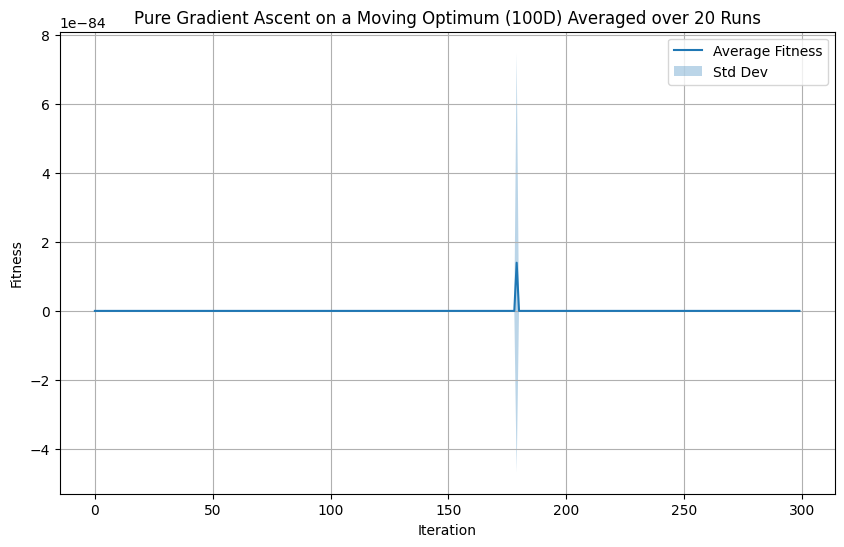

In [56]:
import numpy as np
import matplotlib.pyplot as plt

# ---- Parameters ----
dim = 100              # Dimensionality
steps = 300            # Total number of iterations per run
n_runs = 20            # Number of independent runs
domain = (-5, 5)       # Domain bounds for each coordinate
sigma = 0.3            # Width of the Gaussian peak
lr = 0.005             # Learning rate for gradient ascent
change_interval = 30   # Optimum moves every 30 steps

# ---- Helper Functions ----
def generate_x_star_seq(num_steps, dim, domain, change_interval):
    """
    Generates a sequence of optimum positions (x_star) over time.
    Every 'change_interval' iterations, a new random optimum is chosen.
    """
    x_star_seq = np.zeros((num_steps, dim))
    current_optimum = np.random.uniform(domain[0], domain[1], size=dim)
    for t in range(num_steps):
        if t % change_interval == 0 and t > 0:
            current_optimum = np.random.uniform(domain[0], domain[1], size=dim)
        x_star_seq[t] = current_optimum
    return x_star_seq

def fitness_fn(x, x_star, sigma=sigma):
    """
    Fitness function: f(x, x_star) = exp(-||x - x_star||^2 / (2*sigma^2)).
    Maximum fitness (1) is reached when x == x_star.
    """
    dist2 = np.sum((x - x_star)**2)
    return np.exp(-dist2 / (2 * sigma**2))

def grad_log_f(x, x_star, sigma=sigma):
    """
    Gradient of log f(x, x_star) where log f(x, x_star) = -||x - x_star||^2/(2*sigma^2).
    The gradient is: ∇ log f(x, x_star) = -(x - x_star) / sigma^2.
    """
    return -(x - x_star) / (sigma**2)

def pure_gradient_ascent_moving(dim, steps, domain, sigma, lr, change_interval):
    """
    Performs pure gradient ascent on a moving optimum.
    Returns the fitness history for one run.
    """
    # Generate the moving optimum sequence.
    x_star_seq = generate_x_star_seq(steps, dim, domain, change_interval)
    # Initialize solution x randomly.
    x = np.random.uniform(domain[0], domain[1], size=dim)
    fitness_history = []
    for t in range(steps):
        current_x_star = x_star_seq[t]
        # Compute fitness for current solution.
        fit = fitness_fn(x, current_x_star, sigma)
        fitness_history.append(fit)
        # Compute gradient of log fitness and update x.
        grad = grad_log_f(x, current_x_star, sigma)
        x = x + lr * grad
        # Ensure x remains within the domain.
        x = np.clip(x, domain[0], domain[1])
    return np.array(fitness_history)

# ---- Run Pure Gradient Ascent for n_runs and Average the Results ----
all_runs = []
for run in range(n_runs):
    run_history = pure_gradient_ascent_moving(dim, steps, domain, sigma, lr, change_interval)
    all_runs.append(run_history)
    print(f"Run {run+1} completed.")

all_runs = np.array(all_runs)  # Shape: (n_runs, steps)
avg_fitness = np.mean(all_runs, axis=0)
std_fitness = np.std(all_runs, axis=0)

# ---- Plot the Average Fitness Over Iterations ----
plt.figure(figsize=(10,6))
plt.plot(avg_fitness, label='Average Fitness')
plt.fill_between(np.arange(steps), avg_fitness - std_fitness, avg_fitness + std_fitness,
                 alpha=0.3, label='Std Dev')
plt.xlabel("Iteration")
plt.ylabel("Fitness")
plt.title(f"Pure Gradient Ascent on a Moving Optimum ({dim}D) Averaged over {n_runs} Runs")
plt.legend()
plt.grid(True)
plt.show()

### Evolution Alone in Dynamic Environment

Evolution Run 1 completed.
Evolution Run 2 completed.
Evolution Run 3 completed.
Evolution Run 4 completed.
Evolution Run 5 completed.
Evolution Run 6 completed.
Evolution Run 7 completed.
Evolution Run 8 completed.
Evolution Run 9 completed.
Evolution Run 10 completed.
Evolution Run 11 completed.
Evolution Run 12 completed.
Evolution Run 13 completed.
Evolution Run 14 completed.
Evolution Run 15 completed.
Evolution Run 16 completed.
Evolution Run 17 completed.
Evolution Run 18 completed.
Evolution Run 19 completed.
Evolution Run 20 completed.


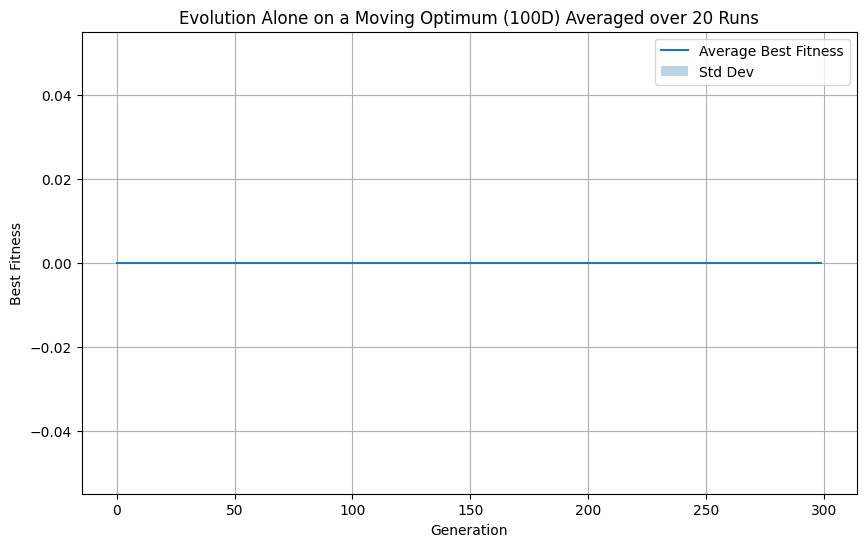

In [58]:
import numpy as np
import matplotlib.pyplot as plt

# ---- Parameters ----
D = 100                   # Dimensionality
pop_size = 20            # Population size
generations = 300         # Number of generations per run
n_runs = 20               # Number of independent runs
domain = [-5, 5]          # Domain bounds for each coordinate
sigma = 0.3               # Width of the Gaussian peak
tournament_size = 3       # Tournament selection size
mutation_rate = 0.1       # Mutation probability per coordinate
mutation_std = 0.1        # Standard deviation for Gaussian mutation
change_interval = 30      # Optimum moves every 30 generations

# ---- Moving Optimum Functions ----
def generate_x_star_seq(num_gens, dim, domain, change_interval):
    """
    Generate a sequence of optimum positions (x_star) for each generation.
    Every 'change_interval' generations, the optimum jumps to a new random position.
    """
    x_star_seq = np.zeros((num_gens, dim))
    current_optimum = np.random.uniform(domain[0], domain[1], size=dim)
    for gen in range(num_gens):
        if gen % change_interval == 0 and gen > 0:
            current_optimum = np.random.uniform(domain[0], domain[1], size=dim)
        x_star_seq[gen] = current_optimum
    return x_star_seq

def fitness_fn(x, x_star, sigma=sigma):
    """
    Fitness function: f(x, x_star) = exp(-||x - x_star||^2 / (2*sigma^2))
    Maximum (1) is achieved when x equals the current optimum x_star.
    """
    dist2 = np.sum((x - x_star)**2)
    return np.exp(-dist2 / (2 * sigma**2))

# ---- Evolution Operators ----
def evaluate_population(pop, current_x_star):
    return np.array([fitness_fn(ind, current_x_star) for ind in pop])

def tournament_selection(pop, fitnesses, tournament_size=tournament_size):
    indices = np.random.choice(np.arange(len(pop)), size=tournament_size, replace=False)
    tournament = pop[indices]
    tournament_fitness = fitnesses[indices]
    best_index = np.argmax(tournament_fitness)
    return tournament[best_index]

def crossover(parent1, parent2):
    alpha = np.random.rand()
    return alpha * parent1 + (1 - alpha) * parent2

def mutate(individual, mutation_std=mutation_std, mutation_rate=mutation_rate, domain=domain):
    for i in range(len(individual)):
        if np.random.rand() < mutation_rate:
            individual[i] += np.random.normal(0, mutation_std)
            individual[i] = np.clip(individual[i], domain[0], domain[1])
    return individual

# ---- Evolution-Only Run Function ----
def run_evolution():
    x_star_seq = generate_x_star_seq(generations, D, domain, change_interval)
    population = np.random.uniform(domain[0], domain[1], (pop_size, D))
    best_fitness_history = []
    
    for gen in range(generations):
        current_x_star = x_star_seq[gen]
        fitnesses = evaluate_population(population, current_x_star)
        best_fit = np.max(fitnesses)
        best_fitness_history.append(best_fit)
        
        new_population = []
        while len(new_population) < pop_size:
            parent1 = tournament_selection(population, fitnesses)
            parent2 = tournament_selection(population, fitnesses)
            offspring = crossover(parent1, parent2)
            offspring = mutate(offspring, mutation_std, mutation_rate, domain)
            new_population.append(offspring)
        population = np.array(new_population)
    
    return best_fitness_history

# ---- Multiple Runs & Averaging ----
all_runs = []
for run in range(n_runs):
    run_history = run_evolution()
    all_runs.append(run_history)
    print(f"Evolution Run {run+1} completed.")

all_runs = np.array(all_runs)  # Shape: (n_runs, generations)
avg_best_fitness = np.mean(all_runs, axis=0)
std_best_fitness = np.std(all_runs, axis=0)

# ---- Plotting the Results ----
plt.figure(figsize=(10,6))
plt.plot(avg_best_fitness, label="Average Best Fitness")
plt.fill_between(np.arange(generations),
                 avg_best_fitness - std_best_fitness,
                 avg_best_fitness + std_best_fitness,
                 alpha=0.3, label="Std Dev")
plt.xlabel("Generation")
plt.ylabel("Best Fitness")
plt.title("Evolution Alone on a Moving Optimum (100D) Averaged over 20 Runs")
plt.legend()
plt.grid(True)
plt.show()

### CMA-ES

-1.1297234740081643e-162
(50_w,100)-aCMA-ES (mu_w=27.0,w_1=8%) in dimension 10 (seed=526090, Mon Mar 31 04:48:56 2025)


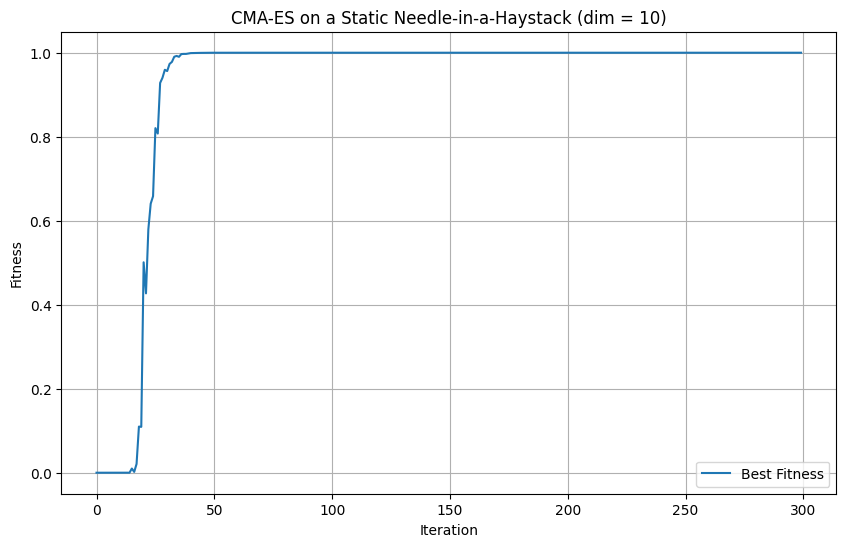

Final best fitness: 1.0


In [82]:
import numpy as np
import cma
import matplotlib.pyplot as plt

# ----- Parameters -----
dim = 10                      # Dimensionality
domain = [-5, 5]               # Bounds for each coordinate
sigma_env = 0.3                # Width of the Gaussian peak
sigma0 = 0.5                   # Initial standard deviation for CMA-ES
pop_size = 100                  # Population size (number of candidates per iteration)
total_iterations = 300         # Total number of iterations

# Static optimum: x* = 0 vector
x_star = np.zeros(dim)

def fitness_fn(x, x_star, sigma=sigma_env):
    """
    Fitness function: f(x, x_star) = exp(-||x - x_star||^2 / (2*sigma^2)).
    Maximum (1) is achieved when x equals x_star.
    """
    dist2 = np.sum((x - x_star)**2)
    return np.exp(-dist2 / (2 * sigma**2))

def objective(x, x_star, sigma=sigma_env):
    """
    Objective function for CMA-ES.
    Since CMA-ES minimizes, we return the negative of the fitness.
    """
    return -fitness_fn(x, x_star, sigma)

# ----- Initialize CMA-ES -----
x0 = np.random.uniform(domain[0], domain[1], dim)  # Initial mean
print(objective(x0, x_star))
options = {'popsize': pop_size, 'bounds': domain, 'verb_disp': 1}
es = cma.CMAEvolutionStrategy(x0, sigma0, options)

# ----- Run CMA-ES -----
fitness_history = []  # Record best fitness per iteration

for iteration in range(total_iterations):
    solutions = es.ask()  # Ask for candidate solutions
    # Evaluate objective (i.e., negative fitness) for each solution
    fitnesses = [objective(x, x_star, sigma_env) for x in solutions]
    es.tell(solutions, fitnesses)
    # Best fitness in this iteration (convert back by taking negative of min objective)
    best_fit = -min(fitnesses)
    fitness_history.append(best_fit)

# ----- Plot Fitness Over Iterations -----
plt.figure(figsize=(10, 6))
plt.plot(np.arange(total_iterations), fitness_history, label="Best Fitness")
plt.xlabel("Iteration")
plt.ylabel("Fitness")
plt.title("CMA-ES on a Static Needle-in-a-Haystack (dim = {})".format(dim))
plt.legend()
plt.grid(True)
plt.show()

print("Final best fitness:", fitness_history[-1])

# Non-differentiable Gaussian Function Variant

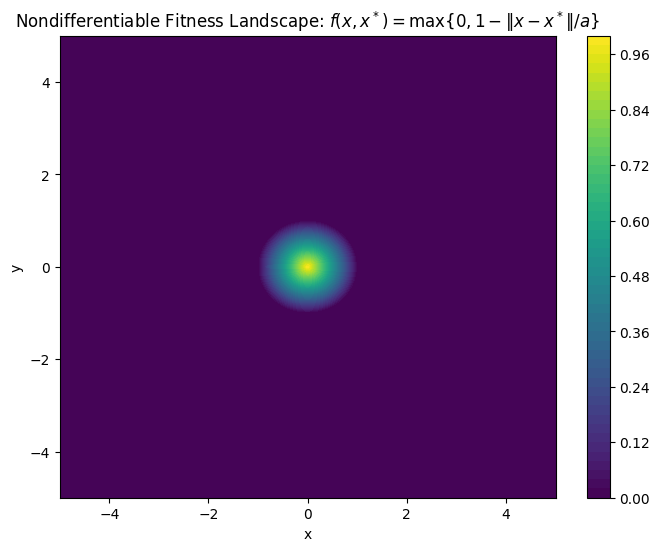

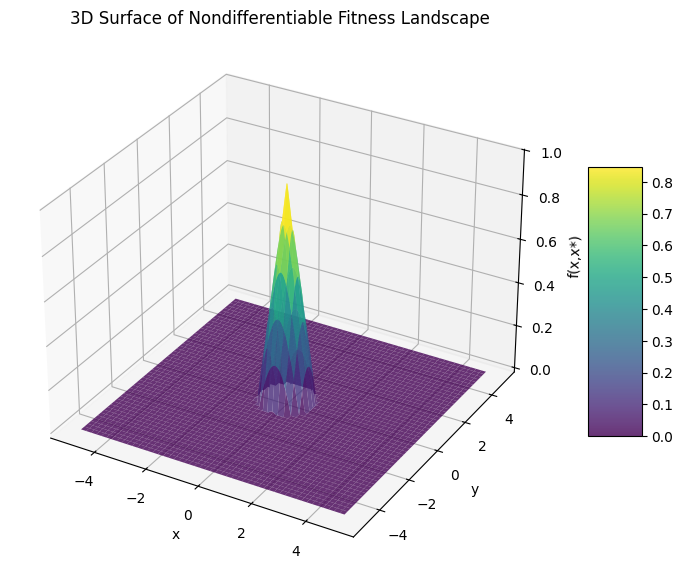

In [86]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # For 3D plotting

# ----- Parameters -----
a = 1.0                      # Parameter controlling the width of the needle
domain = [-5, 5]             # Domain bounds for each coordinate (for visualization)
x_star = np.array([0.0, 0.0])  # The optimum location

def nondiff_fitness_fn(x, x_star, a=a):
    """
    Nondifferentiable fitness function:
    f(x, x_star) = max(0, 1 - ||x - x_star|| / a)
    Maximum (1) is achieved when x equals x_star.
    """
    dist = np.linalg.norm(x - x_star)
    return max(0, 1 - (dist / a))

# ----- Create a Grid for Visualization (2D) -----
x_vals = np.linspace(domain[0], domain[1], 400)
y_vals = np.linspace(domain[0], domain[1], 400)
X, Y = np.meshgrid(x_vals, y_vals)
Z = np.zeros_like(X)

for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        point = np.array([X[i, j], Y[i, j]])
        Z[i, j] = nondiff_fitness_fn(point, x_star, a)

# ----- 2D Contour Plot -----
plt.figure(figsize=(8, 6))
contour = plt.contourf(X, Y, Z, levels=50, cmap='viridis')
plt.colorbar(contour)
plt.title(r"Nondifferentiable Fitness Landscape: $f(x,x^*) = \max\{0, 1-\|x-x^*\|/a\}$")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

# ----- 3D Surface Plot -----
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none', alpha=0.8)
ax.set_title("3D Surface of Nondifferentiable Fitness Landscape")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("f(x,x*)")
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

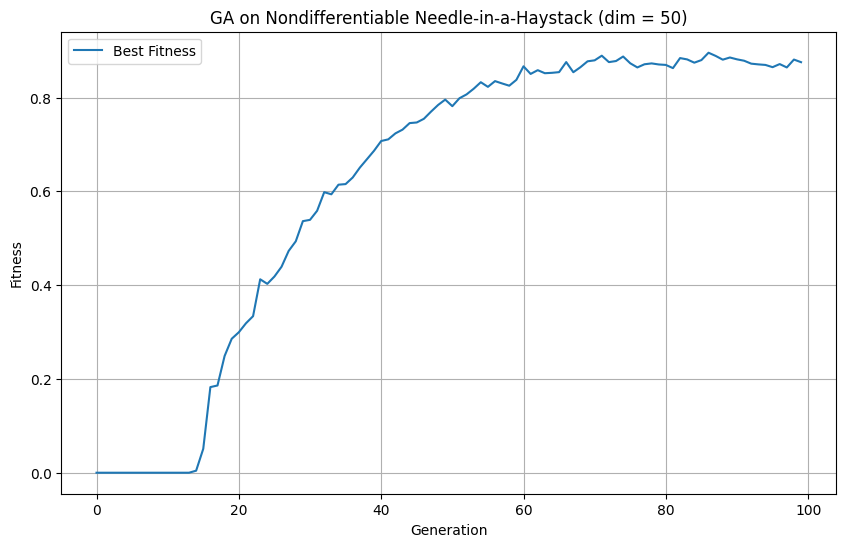

Final best fitness: 0.8753342382253292


In [119]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(2025)

# ----- Parameters -----
dim = 50                      # Dimensionality of the problem
pop_size = 1000                 # Population size
generations = 100             # Number of generations per run
domain = [-5, 5]              # Bounds for each coordinate
a = 1.0                       # Parameter controlling the width of the needle
x_star = np.zeros(dim)        # The optimum is at the zero vector

# ----- Nondifferentiable Fitness Function -----
def nondiff_fitness_fn(x, x_star, a=a):
    """
    Nondifferentiable fitness function:
    f(x, x_star) = max(0, 1 - ||x - x_star|| / a)
    Maximum (1) is achieved when x equals x_star.
    """
    dist = np.linalg.norm(x - x_star)
    return max(0, 1 - (dist / a))

# ----- GA Operators -----
def evaluate_population(pop, x_star):
    """
    Evaluate fitness for each individual in the population.
    Returns an array of fitness values.
    """
    return np.array([nondiff_fitness_fn(ind, x_star, a) for ind in pop])

def tournament_selection(pop, fitnesses, tournament_size=3):
    """
    Perform tournament selection: pick the best individual among a random subset.
    """
    indices = np.random.choice(np.arange(len(pop)), size=tournament_size, replace=False)
    tournament = pop[indices]
    tournament_fitness = fitnesses[indices]
    best_index = np.argmax(tournament_fitness)
    return tournament[best_index]

def crossover(parent1, parent2):
    """
    Arithmetic crossover: combine two parents using a random weight.
    """
    alpha = np.random.rand()
    return alpha * parent1 + (1 - alpha) * parent2

def mutate(individual, mutation_std=0.1, mutation_rate=0.1, domain=domain):
    """
    Mutate an individual by adding Gaussian noise to each coordinate with probability mutation_rate.
    """
    for i in range(len(individual)):
        if np.random.rand() < mutation_rate:
            individual[i] += np.random.normal(0, mutation_std)
            individual[i] = np.clip(individual[i], domain[0], domain[1])
    return individual

# ----- GA Run Function -----
def run_ga():
    """
    Run the GA for 'generations' generations.
    Returns the history of best fitness per generation.
    """
    # Initialize population uniformly in the domain.
    population = np.random.uniform(domain[0], domain[1], (pop_size, dim))
    best_fitness_history = []
    
    for gen in range(generations):
        # Evaluate fitness: using the static optimum x_star.
        fitnesses = evaluate_population(population, x_star)
        best_fit = np.max(fitnesses)
        best_fitness_history.append(best_fit)
        
        new_population = []
        while len(new_population) < pop_size:
            parent1 = tournament_selection(population, fitnesses, tournament_size=3)
            parent2 = tournament_selection(population, fitnesses, tournament_size=3)
            offspring = crossover(parent1, parent2)
            offspring = mutate(offspring, mutation_std=0.1, mutation_rate=0.1, domain=domain)
            new_population.append(offspring)
        population = np.array(new_population)
    
    return np.array(best_fitness_history)

# ----- Run the GA and Plot the Results -----
fitness_history = run_ga()

plt.figure(figsize=(10, 6))
plt.plot(np.arange(generations), fitness_history, label="Best Fitness")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("GA on Nondifferentiable Needle-in-a-Haystack (dim = {})".format(dim))
plt.legend()
plt.grid(True)
plt.show()

print("Final best fitness:", fitness_history[-1])